In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41303")

# Import

In [2]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools
import matplotlib.colors as mcolors
import glob, os
from scipy import ndimage
from random import randrange

In [3]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [4]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [5]:
print(torch.__version__)

1.12.1.post201


In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Useful functions

In [7]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

For testing

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [8]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    file_name = glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[-1]
    print(file_name)
    for event in EventFileLoader(file_name).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

# Data properties

In [9]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [10]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [11]:
features_to_add_to_sample = ['sosstsst', 'sosstsst_var', 'diff_sosstsst_sqr', 'rho_ct_ct']

In [12]:
h = 45 # height of images
w = 40 # width of images

In [13]:
batch_size = 20

# Data classes

## Pytorch dataset (from xarray to torch tensors)

In [14]:
# iterates over time snapshots in an xarray data file and transforms it into a dictionary of pytorch tensors, also performs normalization
class torchDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, transform=None):
        self.transform = transform
        full_data_file_len = len(xarray_dataset.t)
        self.data = (xarray_dataset.isel(x_c=slice(None,w), y_c=slice(None,h))).load()
        self.data_file_len = len(self.data.t)
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(t=list_idx)
        
        # create dictionary of a sample (a batch) containig different features in numpy format. 
        # This dictionary is an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        sample['mask'] = (selected_time_frames['mask'].values).astype(bool)
        #sample['mask'] = selected_time_frames['votemper'].where(not(selected_time_frames['votemper'].isnan())).values.astype(bool)
        erosion_structure_matrix = np.array([(0,0,1,0,0), (0,1,1,1,0), (1,1,1,1,1), (0,1,1,1,0), (0,0,1,0,0)])
        sample['eroded_mask'] = ndimage.binary_erosion(selected_time_frames['mask'].values, structure=erosion_structure_matrix)
        for feature in features_to_add_to_sample :
            sample['mean_'+feature] = self.data['mean_'+feature].values
            sample['std_'+feature] = self.data['std_'+feature].values
            sample[feature] = selected_time_frames[feature].values
            sample['normalized_'+feature] = selected_time_frames['normalized_'+feature].values
        if self.transform:
            sample = self.transform(sample)
        return sample

In [15]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for feature in features_to_add_to_sample :
            transformed_sample[feature] = torch.tensor(sample[feature])
        return transformed_sample

## Lightning data module (split trainig, validation and test data)

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models, which enabeles simple procedure of comparison.

In [16]:
class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, cloud_data_sets, batch_size) :
        super().__init__()
        self.cloud_data_sets = cloud_data_sets
        self.batch_size = batch_size
        self.list_of_xr_datasets = [xr.Dataset() for i in range(len(self.cloud_data_sets))]
        self.list_of_torch_datasets = [{} for i in range(len(self.cloud_data_sets))]
        
    #def prepare_data(self) :
        client.restart()
        # preparation of data: mean and std of the dataset (to avoid batch avg), normalization and nan filling
        for i in range(len(self.cloud_data_sets)) :
            # read file
            xr_dataset = xr.open_zarr(f'{SCRATCH_BUCKET}/data'+str(i)+'.zarr', chunks='auto')[features_to_add_to_sample + ['mask']]
            for feature in features_to_add_to_sample :
                # reapply mask (to avoid issues with nans written in netcdf files)
                xr_dataset[feature] = xr_dataset[feature].where(xr_dataset.mask>0)
                # compute mean, median and std for each level (since temperature/salinity may change a lot with the depth)
                xr_dataset['mean_'+feature] = (xr_dataset[feature].mean())
                xr_dataset['std_'+feature] = (xr_dataset[feature].std())
                # fill nans with mean (doesn't the number to be fillted in matter since they will be masked, 
                # but they have to be filled with any numbers so that nans do not propagate everywhere) 
                xr_dataset[feature] = xr_dataset[feature].fillna(xr_dataset['mean_'+feature])
                # normalize data by shifting with mean value and dividing by std (mean and std are computed above for each vertical level)
                xr_dataset['normalized_'+feature] = ((xr_dataset[feature]-xr_dataset['mean_'+feature])/xr_dataset['std_'+feature]) 
            # save result in a list
            self.list_of_xr_datasets[i] = xr_dataset
            self.list_of_torch_datasets[i] = torchDataset(xr_dataset, transform=ToTensor())
            
    def setup(self, stage: str) :
        if (stage == 'fit') :
        # takes first 60% of time snapshots for training
            self.train_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(dataset, \
                                                                                     indices=range(0,int(0.6*len(dataset)))) \
                                                                                     for dataset in self.list_of_torch_datasets])
        # takes last 20% of time snapshots for validation (we keep a gap to have validation data decorrelated from trainig data)
            self.val_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(dataset, \
                                                                                     indices=range(int(0.8*len(dataset)),len(dataset))) \
                                                                                     for dataset in self.list_of_torch_datasets])
        # same for test
        if (stage == 'test') :
            self.test_datasets = [torch.utils.data.Subset(dataset, indices=range(int(0.8*len(dataset)),len(dataset))) \
                                                               for dataset in self.list_of_torch_datasets]
            
                
    def train_dataloader(self) :
        # create training dataloadder from train_dataset with shuffling with given batch size
        return torch.utils.data.DataLoader(self.train_dataset, \
                                           batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)
    
    def val_dataloader(self) :
        # create training dataloadder from val_dataset without shuffling with the same batch size
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, drop_last=True, num_workers=0) 
    
    def test_dataloader(self) :
        # create a LIST of dataloaders (a dataloader for each dataset) - to enable diagnostics in each region/season individually 
        # batch size is equal to the dataset length, i.e. there is ONLY 1 batch with all dataset inside (can be better since there is no optimisation in testing)
        return [torch.utils.data.DataLoader(dataset, batch_size=len(dataset), drop_last=True, num_workers=0) for dataset in self.test_datasets]
    
    def teardown(self, stage : str) :
        if (stage == 'fit') :
            # clean train and val datasets to free memory
            del self.train_dataset, self.val_dataset
        # if (stage == 'test') :
        #     del self.test_datasets   
        # if (stage == 'predict') :
        #     del self.test_datasets   
        
    def tensor_restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature][:,None,None])+sample['mean_'+reference_feature][:,None,None]

    def tensor_normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature][:,None,None])/(sample['std_'+reference_feature][:,None,None])

## Initialize datamodule

In [17]:
%%time
datamodule = PyLiDataModule(data_dict, batch_size=batch_size)

CPU times: user 3.07 s, sys: 1.36 s, total: 4.42 s
Wall time: 21.8 s


To test:

In [18]:
%%time
datamodule.prepare_data()

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [19]:
%%time 
datamodule.setup(stage='fit')

CPU times: user 60 µs, sys: 17 µs, total: 77 µs
Wall time: 80.1 µs


In [20]:
test_dl = datamodule.train_dataloader()

In [21]:
%%time
test_di = iter(test_dl)

CPU times: user 1.38 ms, sys: 103 µs, total: 1.48 ms
Wall time: 855 µs


In [22]:
%%time
sample = next(test_di)

CPU times: user 29 ms, sys: 2.25 ms, total: 31.3 ms
Wall time: 30.4 ms


In [23]:
sample['sosstsst'].shape

torch.Size([20, 45, 40])

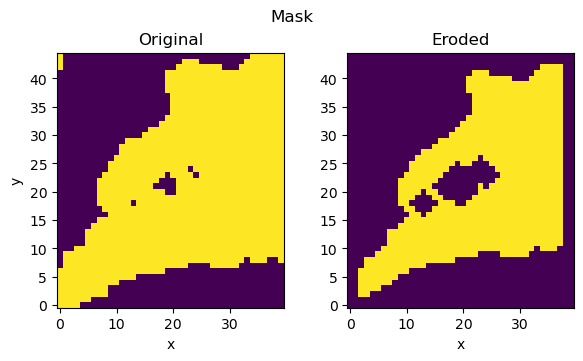

In [24]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3.5))
index = 7
fig.suptitle('Mask')
ax[0].imshow((sample['mask'][:,None,:,:])[0,0], vmin=0, origin='lower')
ax[1].imshow((sample['eroded_mask'][:,None,:,:])[0,0], vmin=0, origin='lower')
ax[0].set(title='Original', xlabel='x', ylabel='y')
ax[1].set(title='Eroded', xlabel='x')
plt.show()

In [25]:
%%time 
datamodule.teardown(stage='fit')

CPU times: user 16 µs, sys: 4 µs, total: 20 µs
Wall time: 25.3 µs


# Grad-based loss function

In [26]:
def central_diffs(dataArray, dim) :
    res = 0.5*(torch.roll(dataArray, shifts=-1, dims=dim) - torch.roll(dataArray, shifts=1, dims=dim))
    return res

In [27]:
def finite_diffs_sqr_2d_array(dataArray, dim_x, dim_y) :
    res = torch.pow(central_diffs(dataArray, dim_x),2) + torch.pow(central_diffs(dataArray, dim_y),2)
    # cut the borders of the image
    res = torch.narrow(res, dim=dim_x, start=1, length=res.shape[dim_x]-2)
    res = torch.narrow(res, dim=dim_y, start=1, length=res.shape[dim_y]-2)
    return res

In [28]:
def gradient_based_MSEloss(outputs, targets, reduction='mean') :
        if (len(outputs.shape) == 3) : # 3D cube (single feature)
            dim_x = 2
            dim_y = 1
        if (len(outputs.shape) == 4) : # 3D cube (multiple features/channels)
            dim_x = 3
            dim_y = 2
        outputs_grad = finite_diffs_sqr_2d_array(outputs, dim_x=dim_x, dim_y=dim_y)
        targets_grad = finite_diffs_sqr_2d_array(targets, dim_x=dim_x, dim_y=dim_y)
        
        value_loss = torch.nn.functional.mse_loss(outputs, targets, reduction=reduction)
        grad_loss = torch.nn.functional.mse_loss(outputs_grad, targets_grad, reduction=reduction)

        return (value_loss+0.1*grad_loss)    

# Generic PyTorch Lightning Module

Logic of trainig, validation and test common for all models

In [29]:
class GenericPyLiModule(pl.LightningModule):
    def __init__(self, torch_model, inputs, outputs, loss, optimizer, learning_rate):
        super().__init__()
        self.torch_model = torch_model
        self.inputs = inputs
        self.outputs = outputs
        self.loss = loss
        self.save_hyperparameters(ignore=['torch_model', 'loss'])
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        
        ## initialization of weights
        #torch_model.weight.data = torch.Tensor([1.0])

        #construct list of names of features to be predicted
        self.list_of_features_to_predict=list()
        for i, feature in enumerate(self.outputs) :
            self.list_of_features_to_predict.append(feature)
            if feature.startswith('normalized_') :
                # if model output is a normalized feature then compute also the non-normalized feature for the diagnostics 
                not_normalized_feature = feature.replace("normalized_", "")
                self.list_of_features_to_predict.append(not_normalized_feature)
        
    def cut_bords(self, tensor, nb_of_border_pix) :
        if nb_of_border_pix is None :
            return tensor
        else :
            return tensor[:, nb_of_border_pix:-nb_of_border_pix, nb_of_border_pix:-nb_of_border_pix] 

    def transform_input(self, batch) :
        # transform dictionary issued from the data loader into 4D torch arrays of shape [N,C,H,W]
        stacked_channels = torch.stack([self.cut_bords(batch[key], self.torch_model.cut_border_pix_input) for key in self.inputs])
        transform = torch.permute(stacked_channels, (1,0,2,3)).to(torch.float32)
        return transform
    
    def transform_target(self, batch) :
        stacked_channels = torch.stack([self.cut_bords(batch[key], self.torch_model.cut_border_pix_output) for key in self.outputs])
        transform = torch.permute(stacked_channels, (1,0,2,3)).to(torch.float32)
        return transform
    
    def transform_mask(self, batch) : 
        nb_of_border_pix = self.torch_model.cut_border_pix_output
        if nb_of_border_pix is None :
            return batch['eroded_mask']
        else :
            return batch['eroded_mask'][:, nb_of_border_pix:-nb_of_border_pix, nb_of_border_pix:-nb_of_border_pix] 

    def evaluate_tensor_metrics_with_mask(self, metrics, mask, truth, model_output, reduction='mean') :
        if (len(model_output.shape) == 3) : # 1 feature (1 channel) - 3D tensor
            batch_len, output_h, output_w = model_output.shape  
            valid_mask_counts = torch.count_nonzero(mask)
            
        if (len(model_output.shape) == 4) : # 4D tensor [N,C,H,W]
            batch_len, nb_of_channels, output_h, output_w = model_output.shape  
            valid_mask_counts = torch.count_nonzero(mask)*nb_of_channels
            mask = mask[:,None,:,:]
            
        if (reduction=='none') : 
            return metrics(model_output*mask, truth*mask, reduction='none')
    
        total_metrics = metrics(model_output*mask, truth*mask, reduction='sum')
        if (reduction=='mean') : 
            return (total_metrics/valid_mask_counts)
        if (reduction=='sum') : 
            return (total_metrics)
        
    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        mask = self.transform_mask(batch)
        
        y_model = self.torch_model(x)
        loss_val = self.evaluate_tensor_metrics_with_mask(self.loss, mask, y_model, y_true)  
        self.log_dict({'loss_train' : loss_val}, on_step=False, on_epoch=True)
        return loss_val

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        mask = self.transform_mask(batch)
        y_model = self.torch_model(x)
        
        loss_val = self.evaluate_tensor_metrics_with_mask(self.loss, mask, y_model, y_true)  
        self.log('loss_val', loss_val, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of batches of 2d fields
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        
        output_4d_tensor = self.torch_model(x)
        batch_len, nb_of_channels, output_h, output_w = output_4d_tensor.shape
        
        mask = self.transform_mask(batch)
        #mask = mask[:,None,:,:]
            
        # construct the dictionary of the predicted features by decomposing the channels in the 4d torch tensor
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            # 1 feature = 1 channel of 4D tensor
            pred[feature] = output_4d_tensor[:, i, :, :]
            # if some outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = PyLiDataModule.tensor_restore_units(pred[feature], batch, not_normalized_feature)
                
        for i, feature in enumerate(self.list_of_features_to_predict):
            pred['mask'] = mask
            pred[feature+'_masked'] = pred[feature].where(mask, torch.ones_like(pred[feature])*np.nan)
        return pred 
    
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        pred = self.predict_step(batch, batch_idx, dataloader_idx)
        mask = self.transform_mask(batch)
        
        test_dict = dict({'loss_val' : dict(), 'loss_grad' : dict(), 'corr_coef' : dict(), 'corr_coef_grad' : dict()})
        dict_for_log = dict()
        for i, feature in enumerate(self.list_of_features_to_predict) :
            truth = self.cut_bords(batch[feature], self.torch_model.cut_border_pix_output)
            model_output = pred[feature]
            
            test_dict['loss_val'][feature] = self.evaluate_tensor_metrics_with_mask(torch.nn.functional.mse_loss, mask, model_output, truth, reduction='mean')
            test_dict['corr_coef'][feature] = torch.corrcoef(torch.vstack((torch.flatten(model_output).view(1,-1), \
                                                              torch.flatten(truth).view(1,-1))))[1,0]
            # metrics on horizontal gradients
            model_output_grad = finite_diffs_sqr_2d_array(model_output, dim_x=2, dim_y=1)
            truth_grad = finite_diffs_sqr_2d_array(truth, dim_x=2, dim_y=1)
            test_dict['loss_grad'][feature] = self.evaluate_tensor_metrics_with_mask(torch.nn.functional.mse_loss, mask[:,1:-1,1:-1], \
                                                                         model_output_grad, \
                                                                         truth_grad, reduction='mean')
            test_dict['corr_coef_grad'][feature] = torch.corrcoef(torch.vstack((torch.flatten(model_output_grad).view(1,-1), \
                                                              torch.flatten(truth_grad).view(1,-1))))[1,0]
            for metrics in list(test_dict.keys()) : 
                dict_for_log.update({(metrics+'_'+feature) : test_dict[metrics][feature]})
        self.log_dict(dict_for_log)

    def configure_optimizers(self) :
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        return optimizer

# Experiment class

This class collects all information needed for an experiment:

In [30]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, torch_model, label, version_name, datamodule, input_features, target_features, loss, optimizer, \
                 learning_rate=0.001, max_epochs=None, limit_train_batches=1.0, **kwargs) :
        super().__init__()
        self.label = label
        self.version_name = version_name
        
        self.pl_class = pl_class  # pytorch lightning module class
        self.torch_model = torch_model
        self.datamodule = datamodule
        self.input_features = input_features
        self.target_features = target_features
        self.loss=loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        self.kwargs = kwargs
        
        # Instantiate pytorch lightning module
        self.pylight_model = self.pl_class(self.torch_model, self.input_features, self.target_features, loss=self.loss, \
                                           optimizer=self.optimizer, learning_rate=self.learning_rate, **self.kwargs)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)

    def run(self) :
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val", save_last=True)
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback],\
                                  accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
        self.trainer.fit(model = self.pylight_model, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_logs(self) :
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_checkpoint_path(self) :
        #file = glob.glob(self.log_directory + self.label + "/" + self.version_name + '/*.ckpt')[-1]
        #print(file)
        file = self.log_directory + self.label + "/" + self.version_name + '/last.ckpt'
        return file
        
    def test(self) :
        return self.trainer.test(self.pylight_model, datamodule=self.datamodule)

# Data structure for experiments

Dictionary of dictionaries for arranging experiments

In [31]:
exp = dict()

In [32]:
exp['LinReg'] = dict()
exp['FCNN'] = dict()
exp['CNN'] = dict()

# Linear regression

## Model

 Torch analog of the deterministic parametrization - linear regreaaion with only 1 parameter aimig to find coefficient $c$ in the parametrization of the form :
 $$ \sigma_T^2 \approx c |\delta \textbf{x} \cdot \nabla T|^2 $$
 where gradient norm is approximated by central finite difference scheme: 
 $$ |\delta \textbf{x} \cdot \nabla T|^2 = \frac{1}{4} \big[ T(x+\delta x,y) - T(x-\delta x, y) \big]^2 + \frac{1}{4} \big[ T(x,y+\delta y) - T(x, y-\delta y) \big]^2 $$

In [33]:
class lin_regr_model(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features):
        super().__init__()
        self.nb_of_input_features = nb_of_input_features
        self.nb_of_output_features = nb_of_output_features
        
        self.cut_border_pix_output = None
        self.cut_border_pix_input = None
        
        self.lin1 = torch.nn.Linear(self.nb_of_input_features, self.nb_of_output_features, bias=False)
        
        # initialization 
        self.lin1.weight.data = torch.Tensor([[0.1]])

    def forward(self, x):
        batch_len, nb_of_channels, output_h, output_w = x.shape
        
        # first split the input 4D torch tensor into individual pixels (equivalent to patches of size 1x1)
        res = torch.nn.functional.unfold(x, kernel_size=1, dilation=1, padding=0, stride=1) #[N,C,HxW]
        res = torch.permute(res, dims=(0,2,1))  #[N,HxW,C]
        res = torch.flatten(res, end_dim=1).to(torch.float32)  #[NxHxW,C]
        
        # perform linear regression
        res = self.lin1(res)
        
        # reshape the model output back to a 4D torch tensor
        res = res.unflatten(dim=0, sizes=[batch_len,-1])  #[N,HxW,C]
        res = torch.permute(res,dims=(0,2,1))     # [N,C,HxW]
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), kernel_size=1, dilation=1, padding=0, stride=1) # [N,C,H,W]

        return res

## Experiments

In [34]:
model_name = 'LinReg'

In [35]:
list_of_exps = ['valueLoss', 'gradLoss']

In [36]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [37]:
input_features_LinReg = ['diff_sosstsst_sqr']
output_features_LinReg = ['sosstsst_var']

In [38]:
exp['LinReg']['valueLoss']['exp'] = Experiment(\
                      pl_class=GenericPyLiModule, \
                      torch_model=lin_regr_model(len(input_features_LinReg), len(output_features_LinReg)), \
                      label='2d_linear_reg', \
                      version_name='masked_temp_var2D', \
                      input_features=input_features_LinReg, \
                      target_features=output_features_LinReg, 
                      datamodule=datamodule,\
                      loss = torch.nn.functional.huber_loss, \
                      optimizer = torch.optim.SGD,\
                      learning_rate = 1e-3,\
                      max_epochs=100, 
                      limit_train_batches=1.0) 

In [39]:
exp['LinReg']['gradLoss']['exp'] = Experiment(\
                      pl_class=GenericPyLiModule, \
                      torch_model=lin_regr_model(len(input_features_LinReg), len(output_features_LinReg)), \
                      label='2d_linear_reg', \
                      version_name='masked_temp_var_grad2D', \
                      input_features=input_features_LinReg, \
                      target_features=output_features_LinReg, 
                      datamodule=datamodule,\
                      loss = gradient_based_MSEloss, \
                      optimizer = torch.optim.SGD,\
                      learning_rate = 1e-4,\
                      max_epochs=100, \
                      limit_train_batches=1.0) 

## Training

In [40]:
# exp['LinReg']['valueLoss']['exp'].run()
# clear_output(wait=True)

In [41]:
# exp['LinReg']['gradLoss']['exp'].run()
# clear_output(wait=True)

logs//2d_linear_reg/masked_temp_var2D/events.out.tfevents.1673386261.jupyter-anastasiagor.2264.0
logs//2d_linear_reg/masked_temp_var_grad2D/events.out.tfevents.1673386363.jupyter-anastasiagor.2264.1


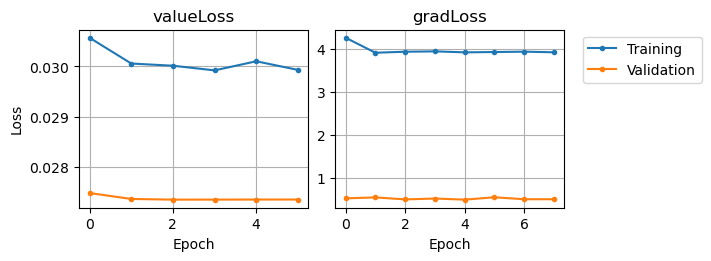

In [42]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5), sharex=False, sharey=False)
exp_model = exp['LinReg']

for i, exp_name in enumerate(exp_model) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0],marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch', yscale='linear')
    ax[i].grid(True)
ax[0].set(ylabel='Loss')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [43]:
for i, exp_name in enumerate(exp_model) :
    experiment = exp['LinReg'][exp_name]['exp']
    model = experiment.pylight_model
    exp['LinReg'][exp_name]['best_model'] = model.load_from_checkpoint(torch_model=model.torch_model, loss=model.loss,\
                                                            checkpoint_path=experiment.get_checkpoint_path(), \
                                                            **experiment.kwargs)
    coef = exp['LinReg'][exp_name]['best_model']
    print(exp_name + ' :' + str(exp['LinReg'][exp_name]['best_model'].torch_model.lin1.weight[0]))

valueLoss :tensor([0.1325], grad_fn=<SelectBackward0>)
gradLoss :tensor([0.2697], grad_fn=<SelectBackward0>)


# Fully-connected NN for patches

## Model

The torch module class describing a model that treats the inputs/outputs by patches of pixels. 

In [44]:
class FCNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, input_patch_size, output_patch_size):
        super().__init__()
        self.input_patch_size = input_patch_size
        self.output_patch_size = output_patch_size
        
        self.lin1 = torch.nn.Linear(nb_of_input_features*input_patch_size**2, 50, bias=True)
        self.lin2 = torch.nn.Linear(50, 50, bias=True)
        self.lin3 = torch.nn.Linear(50, nb_of_output_features*output_patch_size**2, bias=True)
        
        self.cut_border_pix_output = self.input_patch_size//2 - self.output_patch_size//2
        self.cut_border_pix_input = None

    def forward(self, x):
        batch_len, nb_of_channels = x.shape[0:2]
        output_h = x.shape[2]-2*(self.cut_border_pix_output)
        output_w = x.shape[3]-2*(self.cut_border_pix_output)
        
        # create patches of size 'input_patch_size' and join them into batches (zero padding - will remove border pixels)
        res = torch.nn.functional.unfold(x, kernel_size=self.input_patch_size, dilation=1, padding=0, stride=1) #[N,Cx9,Nb_of_patches]
        res = torch.permute(res, dims=(0,2,1))   #[N,Nb_of_patches,Cx9]
        res = torch.flatten(res, end_dim=1)      #[NxNb_of_patches,Cx9]
        
        # pass though the FCNN
        res = self.lin1(res)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        
        # reshape the output patches back into a 4D torch tensor
        res = res.unflatten(dim=0, sizes=(batch_len,-1))
        res = torch.permute(res,dims=(0,2,1))
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), \
                                       kernel_size=self.output_patch_size, dilation=1, padding=0, stride=1)
        # compute the divider needed to get correct values in case of overlapping patches (will give mean over all overlapping patches)
        mask_ones = torch.ones((1,1,output_h,output_w)).to(x.device)
        divisor = torch.nn.functional.fold(torch.nn.functional.unfold(mask_ones, kernel_size=self.output_patch_size), \
                                           kernel_size=self.output_patch_size, output_size=(output_h,output_w))   
        res = res/divisor.view(1,1,output_h,output_w)
        
        return res

## Experiments

In [45]:
model_name = 'FCNN'

In [46]:
list_of_exps = ['patch_3-1', 'patch_5-3']
#list_of_exps = ['patch_3-1', 'patch_5-3', 'patch_3-1_gradLoss', 'patch_5-3_gradLoss']

In [47]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [48]:
input_features_FCNN = ['sosstsst']
output_features_FCNN = ['sosstsst_var']

In [49]:
exp['FCNN']['patch_3-1']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=3, output_patch_size=1), \
                      label='FCNN_patched', \
                      version_name='mask_var_patch_3-1_2D', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

In [50]:
exp['FCNN']['patch_5-3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=5, output_patch_size=3), \
                      label='FCNN_patched', \
                      version_name='mask_var_patch_5-3_2D', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=100, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4)

In [51]:
# exp['FCNN']['patch_3-1_gradLoss']['exp'] = Experiment(pl_class=GenericPyLiModule, \
#                       torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
#                                        input_patch_size=3, output_patch_size=1), \
#                       label='FCNN_patched', \
#                       version_name='mask_var_patch_3-1_3D_grad', \
#                       input_features=input_features_FCNN, \
#                       target_features=output_features_FCNN, \
#                       datamodule=datamodule,\
#                       max_epochs=50, \
#                       limit_train_batches=1.0,
#                       loss = gradient_based_MSEloss,\
#                       optimizer = torch.optim.Adam,\
#                       learning_rate=1e-3) 

In [52]:
# exp['FCNN']['patch_5-3_gradLoss']['exp'] = Experiment(pl_class=GenericPyLiModule, \
#                       torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
#                                        input_patch_size=5, output_patch_size=3), \
#                       label='FCNN_patched', \
#                       version_name='mask_var_patch_5-3_3D_grad', \
#                       input_features=input_features_FCNN, \
#                       target_features=output_features_FCNN, \
#                       datamodule=datamodule,\
#                       max_epochs=100, \
#                       limit_train_batches=1.0,\
#                       loss = gradient_based_MSEloss,\
#                       optimizer = torch.optim.Adam,\
#                       learning_rate=1e-3)

## Training

In [53]:
# exp['FCNN']['patch_3-1']['exp'].run()
# clear_output(wait=True)

In [54]:
# exp['FCNN']['patch_5-3']['exp'].run()
# clear_output(wait=True)

In [55]:
# exp['FCNN']['patch_3-1_gradLoss']['exp'].run()
# clear_output(wait=True)

In [56]:
# exp['FCNN']['patch_5-3_gradLoss']['exp'].run()
# clear_output(wait=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


logs//FCNN_patched/mask_var_patch_3-1_2D/events.out.tfevents.1673386500.jupyter-anastasiagor.2264.2
logs//FCNN_patched/mask_var_patch_5-3_2D/events.out.tfevents.1673386762.jupyter-anastasiagor.2264.3


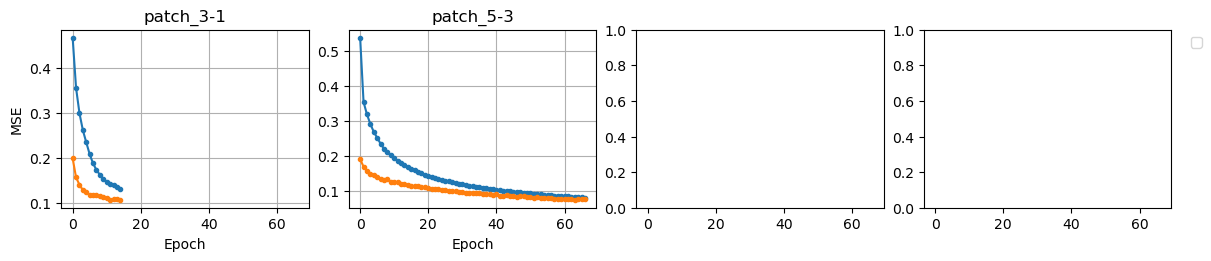

In [57]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(12, 2.5), sharex=True)
exp_model = exp['FCNN']

#for i, exp_name in enumerate(['patch_3-1', 'patch_5-3', 'patch_3-1_gradLoss', 'patch_5-3_gradLoss']) :
for i, exp_name in enumerate(['patch_3-1', 'patch_5-3']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], \
               marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], \
               marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch'); ax[i].grid(True)
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Convolutional NN model

## Model

In [58]:
class CNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, padding='same', padding_mode='replicate', kernel_size=3):
        super().__init__()
        self.padding = padding
        self.kernel_size = kernel_size
        self.padding_mode = 'replicate'
        
        self.cut_border_pix_input = None
        if self.padding == 'same' :
            self.cut_border_pix_output = self.cut_border_pix_input
        if self.padding == 'valid' :
            self.cut_border_pix_output = (self.cut_border_pix_input or 0) + self.kernel_size//2
        
        self.conv1 = torch.nn.Conv2d(in_channels=nb_of_input_features, out_channels=64, kernel_size=self.kernel_size, \
                                     padding=self.padding,  padding_mode=self.padding_mode) 
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv3 = torch.nn.Conv2d(64, nb_of_output_features, kernel_size=self.kernel_size, padding='same', \
                                     padding_mode=self.padding_mode)

    def forward(self, x):
        batch_len = x.shape[0]
        
        res = self.conv1(x)
        res = torch.nn.functional.relu(res)
        res = self.conv2(res)
        res = torch.nn.functional.relu(res)
        res = self.conv3(res)
        return res        

## Experiments

In [59]:
model_name = 'CNN'

In [60]:
list_of_exps = ['kernel3', 'kernel5']#, 'kernel7']

In [61]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [62]:
input_features_CNN = input_features_FCNN
output_features_CNN = output_features_FCNN

In [63]:
exp['CNN']['kernel3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=3),\
                      label='CNN', \
                      version_name='mask_kernel3_2D', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

In [64]:
exp['CNN']['kernel5']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=5),\
                      label='CNN', \
                      version_name='mask_kernel5_2D', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.functional.mse_loss,\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

## Training

In [65]:
# exp['CNN']['kernel3']['exp'].run()
# clear_output(wait=True)

In [66]:
# exp['CNN']['kernel5']['exp'].run()
# clear_output(wait=True)

logs//CNN/mask_kernel3_2D/events.out.tfevents.1673387948.jupyter-anastasiagor.2264.4
logs//CNN/mask_kernel5_2D/events.out.tfevents.1673388398.jupyter-anastasiagor.2264.5


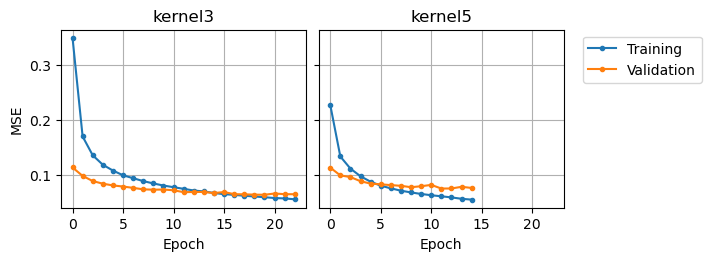

In [67]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5), sharex=True, sharey=True)
exp_model = exp['CNN']

for i, exp_name in enumerate(['kernel3', 'kernel5']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[i].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], \
               marker='.', label='Training')
    ax[i].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], \
               marker='.', label='Validation')
    ax[i].set(title=exp_name, xlabel='Epoch'); ax[i].grid(True)
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Evaluation and comparison

In [68]:
%%time
test_datamodule = datamodule
test_datamodule.setup(stage='test')

CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 51 µs


In [69]:
list_of_models = ['LinReg', 'CNN', 'FCNN']

In [70]:
%%time
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['exp'].pylight_model
        exp_dict['best_model'] = model.load_from_checkpoint(torch_model=model.torch_model, loss=model.loss,\
                                                            checkpoint_path=exp_dict['exp'].get_checkpoint_path(), \
                                                            **exp_dict['exp'].kwargs)
        trainer = pl.Trainer(accelerator='gpu', devices=1)
        print(model_name + ' ' + exp_name)
        test_dict = trainer.test(exp_dict['best_model'], datamodule=test_datamodule)
        test_dict_metrics_keys = ['loss_val', 'loss_grad', 'corr_coef', 'corr_coef_grad']
        for key in test_dict_metrics_keys : 
            exp_dict.update({key : dict()})
            for feature in ['sosstsst_var'] :
                exp_dict[key][feature] = [test_dict[ds][key+'_'+feature+'/dataloader_idx_'+str(ds)] for ds in range(len(data_dict))]
        
        # save prediction
        prediction_dict = trainer.predict(exp_dict['best_model'], dataloaders=test_datamodule.test_dataloader())
        exp_dict['pred'] = dict()
        for feature in list(prediction_dict[0][0].keys()) :
            exp_dict['pred'][feature] = [prediction_dict[ds][0][feature] for ds in range(len(data_dict))]
        del prediction_dict

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg valueLoss


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.7017507553100586         0.7641284465789795         0.5873857140541077
  corr_coef_sosstsst_var       0.7137858271598816         0.7573877573013306         0.7858014106750488
  loss_grad_sosstsst_var       22.571802139282227         1.2405765056610107          1.241850733757019
   loss_val_sosstsst_var       0.5895199179649353         0.11330083012580872       0.048787787556648254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg gradLoss


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.7017486095428467          0.764133632183075         0.5873860716819763
  corr_coef_sosstsst_var       0.7137903571128845         0.7573882341384888         0.7858011722564697
  loss_grad_sosstsst_var       14.561408996582031         0.7787238359451294         3.0962679386138916
   loss_val_sosstsst_var       0.7560572624206543         0.16547530889511108        0.13401468098163605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.48387420177459717        0.6366937160491943          0.539580762386322
  corr_coef_sosstsst_var        0.522261381149292         0.6113770604133606         0.6583712100982666
  loss_grad_sosstsst_var       11.564531326293945         0.6502019762992859         1.4693210124969482
   loss_val_sosstsst_var       0.23952633142471313       0.049570392817258835         0.090391144156456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.7378236055374146         0.7451677918434143         0.4595451354980469
  corr_coef_sosstsst_var       0.6841256022453308         0.7028253078460693         0.5100597143173218
  loss_grad_sosstsst_var       13.008484840393066         0.7344959378242493         1.2562488317489624
   loss_val_sosstsst_var       0.27404436469078064       0.053545355796813965        0.11568661034107208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_3-1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.7589209675788879         0.7363485097885132         0.48349514603614807
  corr_coef_sosstsst_var       0.7146953344345093         0.6719198226928711         0.6871252655982971
  loss_grad_sosstsst_var       17.737808227539062         1.2609807252883911         1.3978896141052246
   loss_val_sosstsst_var       0.4614899158477783         0.10372024029493332        0.07097802311182022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_5-3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0               DataLoader 1               DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
corr_coef_grad_sosstsst_var    0.7724708914756775         0.7575974464416504         0.5803250670433044
  corr_coef_sosstsst_var       0.7069559693336487         0.6987196207046509         0.5777848362922668
  loss_grad_sosstsst_var       15.462759017944336         0.7356449961662292         1.2504644393920898
   loss_val_sosstsst_var       0.32355475425720215       0.058070044964551926        0.07978920638561249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

CPU times: user 44 s, sys: 5.16 s, total: 49.1 s
Wall time: 51 s


## Image examples

True fields:

In [71]:
truth = dict()
for feature in ['sosstsst_var'] :
    truth[feature] = [torch.Tensor() for i in range(len(test_datamodule.test_dataloader()))]

In [72]:
for i, dataloader in enumerate(test_datamodule.test_dataloader()) :
    iterator = iter(dataloader)
    sample = next(iterator)
    for feature in ['sosstsst_var'] :
        truth[feature][i] = sample[feature].where(sample['mask'][:,:,:], torch.ones_like(sample['mask'][:,:,:])*np.nan)

In [73]:
idx_batch = 0

In [74]:
feature = 'sosstsst_var_masked'

In [75]:
selected_idx_region = [0,3,5]

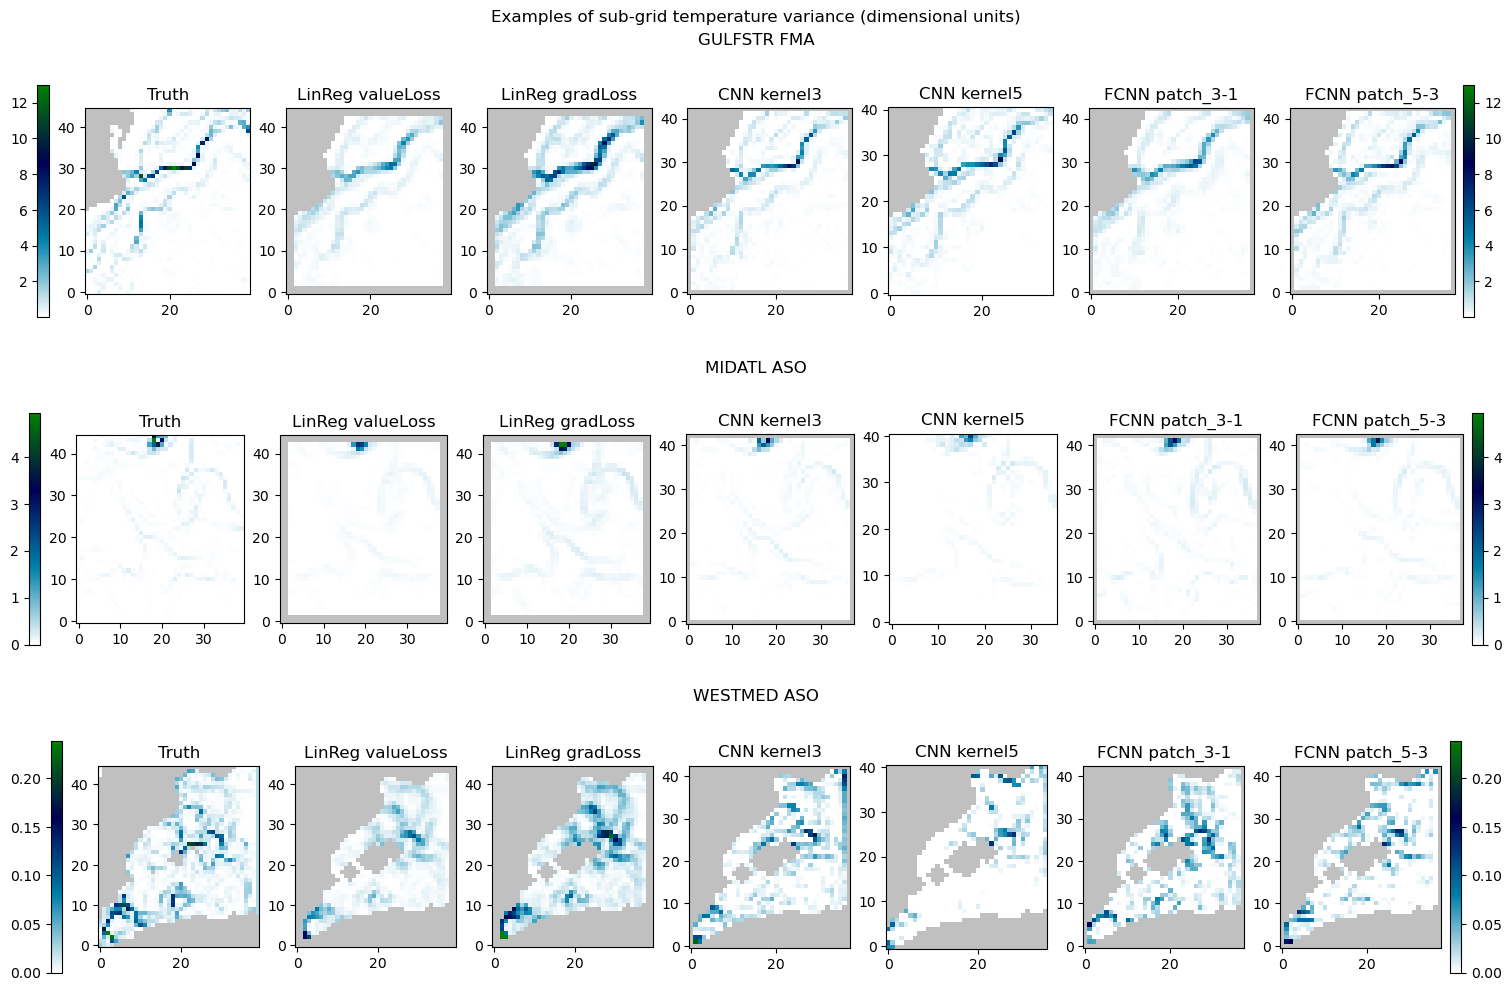

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(15,10),sharex=True, sharey=True)
fig.suptitle('Examples of sub-grid temperature variance (dimensional units)')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    idx_region = selected_idx_region[row]
    axs = subfig.subplots(ncols=7, nrows=1)
    img = axs[0].imshow(truth['sosstsst_var'][idx_region][idx_batch,:,:], \
                        #cmap=('ocean_r' if (row==0) else current_cmap), \
                        cmap='ocean_r', \
                        #vmin=(None if (row==0) else color_min), vmax=(None if (row==0) else color_max), \
                        origin='lower')
    fig.colorbar(img, location='left',  shrink=0.8)
    axs[0].set(title='Truth')
    #if (row == 0) :
    color_min = img.colorbar.vmin
    color_max = img.colorbar.vmax
    current_cmap = img.cmap
    current_cmap.set_bad(color='silver')
    ax_index = 1
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())[0:4]) :
            exp_dict = exp[model_name][exp_name]
            img = axs[ax_index].imshow(exp_dict['pred']['sosstsst_var_masked'][idx_region][idx_batch,:,:], cmap=current_cmap, \
                                       vmin=color_min, vmax=color_max, origin='lower')
            axs[ax_index].set(title=model_name+' '+exp_name)
            ax_index+=1
    fig.colorbar(img, ax=axs[-1], shrink=0.8)
    subfigs[row].suptitle(data_dict[idx_region]['label'])
plt.show()

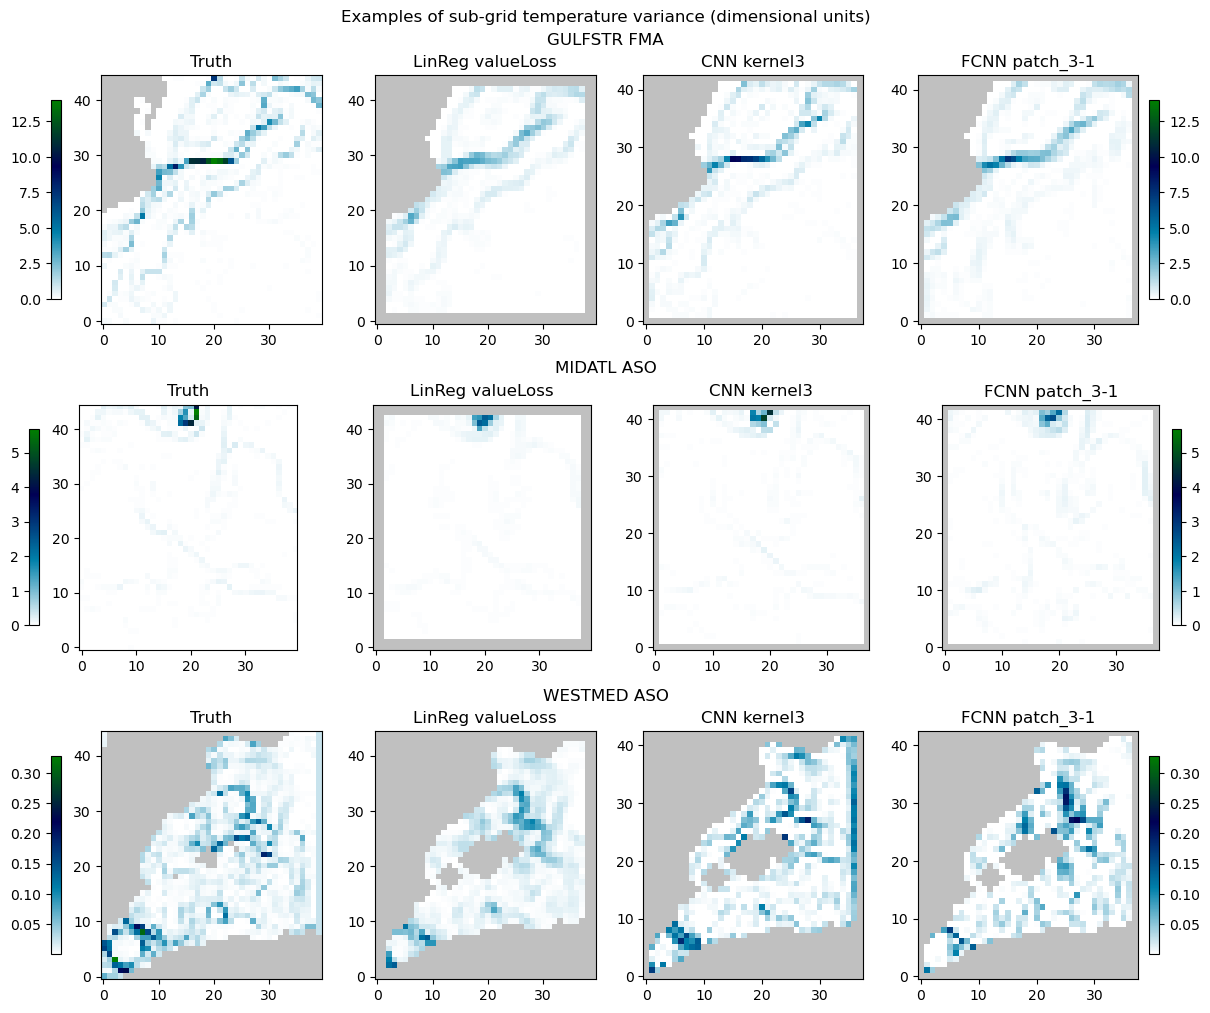

In [77]:
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(12,10),sharex=True, sharey=True)
fig.suptitle('Examples of sub-grid temperature variance (dimensional units)')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]
idx_batch = 100
for row, subfig in enumerate(subfigs):
    idx_region = selected_idx_region[row]
    axs = subfig.subplots(ncols=4, nrows=1)
    img = axs[0].imshow(truth['sosstsst_var'][idx_region][idx_batch,:,:], \
                        #cmap=('ocean_r' if (row==0) else current_cmap), \
                        cmap='ocean_r', \
                        #vmin=(None if (row==0) else color_min), vmax=(None if (row==0) else color_max), \
                        origin='lower')
    fig.colorbar(img, location='left',  shrink=0.8)
    axs[0].set(title='Truth')
    #if (row == 0) :
    color_min = img.colorbar.vmin
    color_max = img.colorbar.vmax
    current_cmap = img.cmap
    current_cmap.set_bad(color='silver')
    ax_index = 1
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())[0:1]) :
            exp_dict = exp[model_name][exp_name]
            img = axs[ax_index].imshow(exp_dict['pred']['sosstsst_var_masked'][idx_region][idx_batch,:,:], cmap=current_cmap, \
                                       vmin=color_min, vmax=color_max, origin='lower')
            axs[ax_index].set(title=model_name+' '+exp_name)
            ax_index+=1
    fig.colorbar(img, ax=axs[-1], shrink=0.8)
    subfigs[row].suptitle(data_dict[idx_region]['label'])
plt.show()

## Metrics over all datasets

In [78]:
bar_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

In [79]:
metrics_list = ['loss_val', 'loss_grad', 'corr_coef', 'corr_coef_grad']

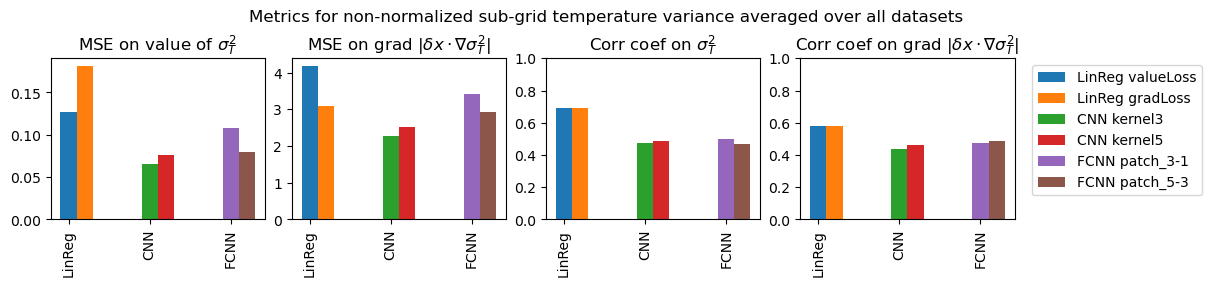

In [80]:
fig, ax = plt.subplots(1, len(metrics_list), constrained_layout=True, figsize=(3.0*len(metrics_list), 2.75))
fig.suptitle('Metrics for non-normalized sub-grid temperature variance averaged over all datasets')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'
for idx, metrics in enumerate(metrics_list) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]

            ax[idx].bar(x[i]+j*bar_width, np.mean(exp_dict[metrics][feature]), width=bar_width, \
                           color=bar_colors[bar_counter],label=model_name+' '+exp_name)
            bar_counter+=1
    ax[idx].set_xticks(x, xlabels, rotation='vertical') 
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax[2::] :
    axis.set(ylim=[0,1])

ax[0].set(title=r'MSE on value of $\sigma_T^2$')
ax[1].set(title=r'MSE on grad $|\delta x \cdot \nabla \sigma_T^2|$')
ax[2].set(title=r'Corr coef on $\sigma_T^2$')
ax[3].set(title=r'Corr coef on grad $|\delta x \cdot \nabla \sigma_T^2|$')
plt.show()

## Compare MSE across datasets (by region/season)

### MSE of subgrid variance

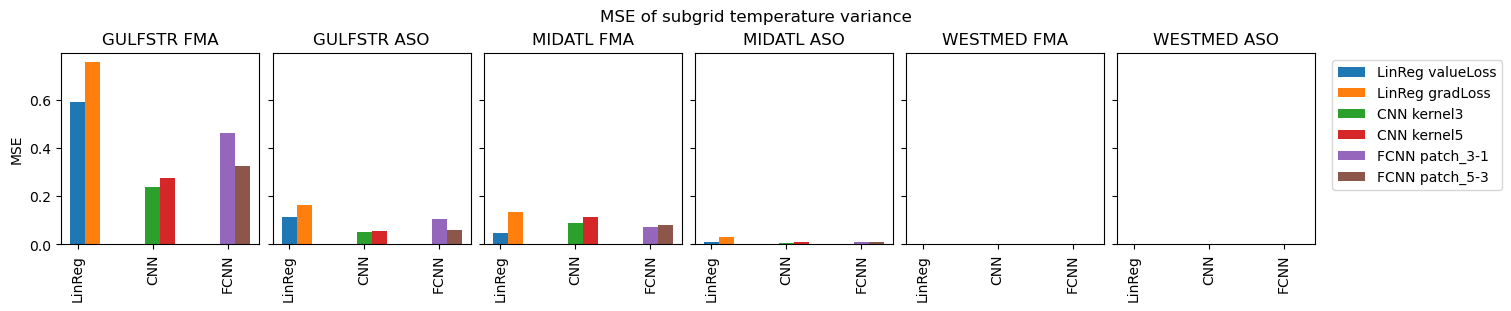

In [81]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharex=True, sharey=True)
fig.suptitle('MSE of subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_val'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_val'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

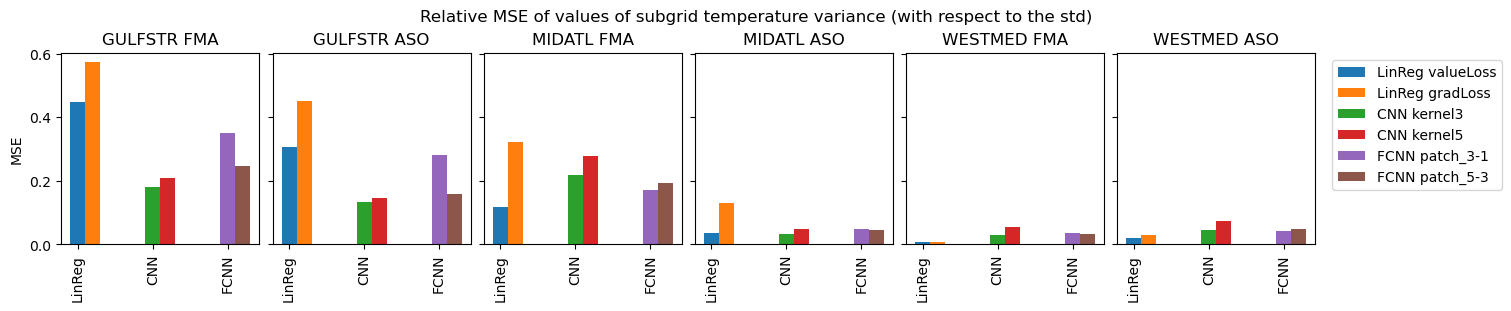

In [82]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharey=True)
fig.suptitle('Relative MSE of values of subgrid temperature variance (with respect to the std)')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_val'].keys()) :
                ax[region].bar(x[i]+j*bar_width, \
                               exp_dict['loss_val'][feature][region]/datamodule.list_of_xr_datasets[region]['std_sosstsst_var'], \
                               width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

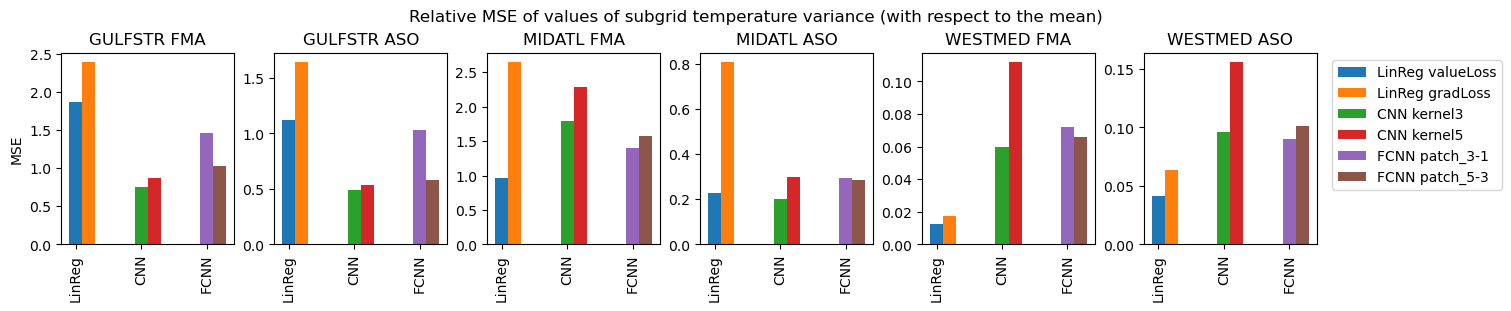

In [83]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('Relative MSE of values of subgrid temperature variance (with respect to the mean)')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_val'].keys()) :
                ax[region].bar(x[i]+j*bar_width, \
                               exp_dict['loss_val'][feature][region]/datamodule.list_of_xr_datasets[region]['mean_sosstsst_var'], \
                               width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### MSE of horizontal gradient of the subgrid variance

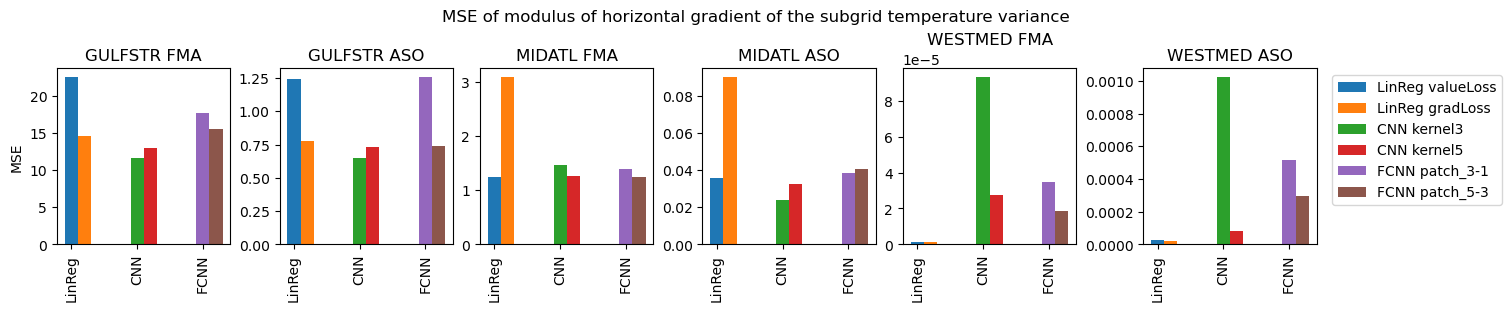

In [84]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of modulus of horizontal gradient of the subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_grad'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_grad'][feature][region], width=bar_width, \
                               color=bar_colors[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()